In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/PASCAL/'

/content/gdrive/MyDrive/PASCAL


In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar

In [ ]:
!tar -xvf VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtest_06-Nov-2007.tar

PASCAL VOC 2007 directory
```
/VOCdevkit//VOC2007/
├── Annotations        
│   └── *.xml
├── ImageSets
│   ├── Layout
│   │   └── *.txt
│   ├── Main
│   │   └── *.txt
│   └── Segmentation
│        └── *.txt
├── JPEGImages
│   └── .jpg
├── SegmentationClass
│   └── *.png
└── SegmentationObject
     └── *.png

```


ImageSets
- class 별 train/val/test txt 파일
- object와 class 일치 여부(일치 : 1, 불일치 : -1) 

Annotations
1. Class : 오브젝트의 클래스
2. Bounding Box: 오브젝트 위치
3. View: 각 오브젝트의 방향
4. Truncated: 오브젝트의 잘림 여부
5. Difficult: 인식 난이도

참조 : [PASCAL VOC 2007 데이터셋 다운로드 및 확인 방법](https://ndb796.tistory.com/500)

In [ ]:
!cat './VOCdevkit/VOC2007/Annotations/000001.xml'

<annotation>
	<folder>VOC2007</folder>
	<filename>000001.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
		<flickrid>341012865</flickrid>
	</source>
	<owner>
		<flickrid>Fried Camels</flickrid>
		<name>Jinky the Fruit Bat</name>
	</owner>
	<size>
		<width>353</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>dog</name>
		<pose>Left</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>48</xmin>
			<ymin>240</ymin>
			<xmax>195</xmax>
			<ymax>371</ymax>
		</bndbox>
	</object>
	<object>
		<name>person</name>
		<pose>Left</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>12</ymin>
			<xmax>352</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>


In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def extract_file(imageset_path, file_type, class_name=""):
    if class_name != "":
        class_name += '_'
    file_path = imageset_path + class_name + file_type + '.txt'

    cls = []

    with open(file_path, 'r') as f:
        reader = f.readlines()
        for line in reader:
            check = line.strip().split(' ')
            if class_name != "":
               if check[-1] == str(1):
                   cls.append(check[0] + '.jpg')
            else:           
                cls.append(check[0] + '.jpg')
    return cls

In [4]:
classes = set()
dir_name = './VOCdevkit/VOC2007/'

imageset = 'ImageSets/Main/'
imageset_path = os.path.join(dir_name, imageset)

annotation = 'Annotations/'
annotation_path = os.path.join(dir_name, annotation)

jpeg = 'JPEGImages/'
jpeg_path = os.path.join(dir_name, jpeg)

class_dir = os.listdir(imageset_path)
annot_dir = os.listdir(annotation_path)
jpeg_dir = os.listdir(jpeg_path)


for cls in class_dir:
    cls = cls.split('/')[-1].split('_')[0]
    if '.txt' not in cls:
        classes.add(cls)

print(len(classes), classes)

20 {'boat', 'train', 'horse', 'cat', 'motorbike', 'tvmonitor', 'bottle', 'person', 'aeroplane', 'bus', 'cow', 'bird', 'diningtable', 'sheep', 'car', 'pottedplant', 'bicycle', 'chair', 'dog', 'sofa'}


In [ ]:
train_data = extract_file(imageset_path, 'train')
test_data = extract_file(imageset_path, 'test')
val_data = extract_file(imageset_path, 'val')

train_data = {f:None for f in train_data}
test_data = {f:None for f in test_data}
val_data = {f:None for f in val_data}

In [ ]:
from xml.etree.ElementTree import parse

def xml_parser(annotation_path, file_name):
    file_name = file_name
    xml_name = file_name.replace('jpg', 'xml')
    dir_path = os.path.join(annotation_path, xml_name)

    tree = parse(dir_path)
    root = tree.getroot()

    cls = dict()
    for obj in root.findall('object'):
        obj_name = obj.find('name').text
        bb = obj.find('bndbox')

        x1 = int(bb.find('xmin').text)
        y1 = int(bb.find('ymin').text)
        x2 = int(bb.find('xmax').text)
        y2 = int(bb.find('ymax').text)
        cls[obj_name] = (x1, y1, x2, y2)

    return cls    

In [ ]:
for data in train_data.keys():
    train_data[data] = xml_parser(annotation_path, data)

for data in test_data.keys():
    test_data[data] = xml_parser(annotation_path, data)

for data in val_data.keys():
    val_data[data] = xml_parser(annotation_path, data)

In [ ]:
with open('train_data.pickle','wb') as fw:
    pickle.dump(train_data, fw)

with open('test_data.pickle','wb') as fw:
    pickle.dump(test_data, fw)
    
with open('val_data.pickle','wb') as fw:
    pickle.dump(val_data, fw)

In [5]:
with open('train_data.pickle', 'rb') as fr:
    train_data = pickle.load(fr)

with open('test_data.pickle', 'rb') as fr:
    test_data = pickle.load(fr)

with open('val_data.pickle', 'rb') as fr:
    val_data = pickle.load(fr)

In [ ]:
max_length = 0
length = []
file_names = []
file_type = ['train'] * len(train_data) + ['test'] * len(test_data) + ['val'] * len(val_data)
objs = []
bb = []

In [ ]:
for data in train_data.keys():
    if max_length <= len(train_data[data]):
        max_length = len(train_data[data])
    file_names.append(data)
    length.append(len(train_data[data]))
    objs.append([key for key in train_data[data].keys()])
    bb.append([train_data[data][key] for key in train_data[data].keys()])

for data in test_data.keys():
    if max_length <= len(test_data[data]):
        max_length = len(test_data[data])
    file_names.append(data)
    length.append(len(test_data[data]))
    objs.append([key for key in test_data[data].keys()])
    bb.append([test_data[data][key] for key in test_data[data].keys()])

for data in val_data.keys():
    if max_length <= len(val_data[data]):
        max_length = len(val_data[data])
    file_names.append(data)
    length.append(len(val_data[data]))
    objs.append([key for key in val_data[data].keys()])
    bb.append([val_data[data][key] for key in val_data[data].keys()])

print(max_length)

7


DataFrame 만들기

파일명(path.jpg)|file_type(train/test/val)|object_length(n개)|object_1|$\cdots$|object_n|object_bb_1|$\cdots$|object_bb_n
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
~.jpg|train|5|'dog'|$\cdots$|None|(2, 4, 100, 120)|$\cdots$|None
$\vdots$||||||||$\vdots$
~.jpg|val|1|'bird'|$\cdots$|None|(20, 38, 29, 48)|$\cdots$|None

In [ ]:
columns = ['file_path', 'file_type', 'obj_length']
obj = ['obj_' + str(i) for i in range(1, max_length + 1)]
obj_bb = ['obj_bb_' + str(i) for i in range(1, max_length + 1)]

columns = columns + obj + obj_bb
print(columns)

['file_path', 'file_type', 'obj_length', 'obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_bb_1', 'obj_bb_2', 'obj_bb_3', 'obj_bb_4', 'obj_bb_5', 'obj_bb_6', 'obj_bb_7']


In [ ]:
for i in range(len(objs)):
    num = max_length - len(objs[i])
    for j in range(num):
        objs[i].append('None')

In [ ]:
for i in range(len(bb)):
    num = max_length - len(bb[i])
    for j in range(num):
        bb[i].append('None')

In [ ]:
obj1 = [obj[0] for obj in objs]
obj2 = [obj[1] for obj in objs]
obj3 = [obj[2] for obj in objs]
obj4 = [obj[3] for obj in objs]
obj5 = [obj[4] for obj in objs]
obj6 = [obj[5] for obj in objs]
obj7 = [obj[6] for obj in objs]

bb1 = [b[0] for b in bb]
bb2 = [b[1] for b in bb]
bb3 = [b[2] for b in bb]
bb4 = [b[3] for b in bb]
bb5 = [b[4] for b in bb]
bb6 = [b[5] for b in bb]
bb7 = [b[6] for b in bb]

In [ ]:
values = [file_names, file_type, length, obj1, obj2, obj3, obj4, obj5, obj6, obj7, bb1, bb2, bb3, bb4, bb5, bb6, bb7]

In [ ]:
d = {}

for i in range(len(values)):
    d[columns[i]] = values[i]

In [ ]:
df = pd.DataFrame(d)
df.to_csv('obj_df.csv', index=False)

In [6]:
dataframe = pd.read_csv('./obj_df.csv')
dataframe.head()

,file_path,file_type,obj_length,obj_1,obj_2,obj_3,obj_4,obj_5,obj_6,obj_7,obj_bb_1,obj_bb_2,obj_bb_3,obj_bb_4,obj_bb_5,obj_bb_6,obj_bb_7
0,000012.jpg,train,1,car,None,None,None,None,None,None,"(156, 97, 351, 270)",None,None,None,None,None,None
1,000017.jpg,train,2,person,horse,None,None,None,None,None,"(185, 62, 279, 199)","(90, 78, 403, 336)",None,None,None,None,None
2,000023.jpg,train,2,bicycle,person,None,None,None,None,None,"(2, 178, 90, 500)","(225, 1, 334, 486)",None,None,None,None,None
3,000026.jpg,train,1,car,None,None,None,None,None,None,"(90, 125, 337, 212)",None,None,None,None,None,None
4,000032.jpg,train,2,aeroplane,person,None,None,None,None,None,"(133, 88, 197, 123)","(26, 189, 44, 238)",None,None,None,None,None


In [ ]:
!pip install selectivesearch

In [14]:
from selectivesearch import selective_search
import matplotlib.patches as patches

image = plt.imread(jpeg_path + dataframe.iloc[2, 0])

_, regions = selective_search(image,
                         scale=100,
                          min_size=2000)

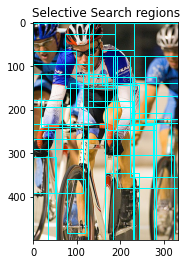

In [64]:
plt.imshow(image)

ax = plt.gca()

plt.title('Selective Search regions')
for idx in range(len(regions)):
    x1, y1, x2, y2 = regions[idx]['rect']
    rect = patches.Rectangle((x1, y1), x2, y2, edgecolor='cyan', fill = False)
    ax.add_patch(rect)

plt.show()

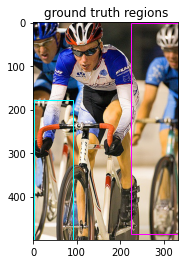

In [68]:
plt.imshow(image)

ax = plt.gca()
plt.title('ground truth regions')
x1, y1, x2, y2 = map(int, dataframe.iloc[2, 10].replace('(', "").replace(')', "").split(', '))
x11, y11, x22, y22 = map(int, dataframe.iloc[2, 11].replace('(', "").replace(')', "").split(', '))

rect = patches.Rectangle((x1, y1), x2, y2, edgecolor='cyan', fill = False)
rect2 = patches.Rectangle((x11, y11), x22, y22, edgecolor='fuchsia', fill = False)
ax.add_patch(rect)
ax.add_patch(rect2)

plt.show()

In [62]:
def selective_search_regions(image):
    image = plt.imread(jpeg_path + dataframe.iloc[2, 0])

    _, regions = selective_search(image,
                            scale=100,
                            min_size=2000)
    
    return regions

In [76]:
def IoU(ground_truth, regions, threshold=0.5):
    g_x1, g_y1, g_x2, g_y2 = map(int, ground_truth.replace('(', '').replace(')', '').split(', '))
    area1 = (g_x2 - g_x1 + 1) * (g_y2 - g_y1 + 1)
    
    iou = []
    for region in regions:
        s_x1, s_y1, s_x2, s_y2 = region['rect']
        area2 = (s_x2 - s_x1 + 1) * (s_y2 - s_y1 + 1)

        m_x1 = max(g_x1, s_x1)
        m_y1 = max(g_y1, s_y1)
        m_x2 = max(g_x2, s_x2)
        m_y2 = max(g_y2, s_y2)

        interArea = max(0, m_x2 - m_x1 + 1) * max(0, m_y2 - m_y1 + 1)

        iou.append(interArea/float(area1 + area2 - interArea))

    return iou

In [ ]:
def region_proposals():
    pass